# Mean-Reversion in Momentum

Replication of strategy outlined in this [cssanalytics](https://cssanalytics.wordpress.com/2019/09/12/when-should-you-buy-momentum-mean-reversion-in-the-momentum-factor/) blog post.

In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

#initialize
indices<-Indices()

In [2]:
#fetch momentum indices published by Barclays Indices

indexMeta <- indices$BarclaysMeta() %>%
    inner_join(indices$BarclaysTimeSeries()) %>%
    filter(NAME %like% '%momentum%') %>%
    group_by(TICKER, FAMILY, NAME) %>%
    summarize(ST = min(TIME_STAMP), ET = max(TIME_STAMP)) %>%
    select(TICKER, FAMILY, NAME, ST, ET) %>%
    arrange(FAMILY) %>%
    collect()

indexMeta %>% print(n = Inf)

# A tibble: 12 x 5
# Groups:   TICKER, FAMILY [12]
   TICKER   FAMILY          NAME                                          
 * <chr>    <chr>           <chr>                                         
 1 BXIIMEEE Equity Momentum Barclays Eurozone Momentum Equity ER EUR Index
 2 BXIIMEPE Equity Momentum Barclays Eurozone Momentum Equity PR EUR Index
 3 BXIIMETE Equity Momentum Barclays Eurozone Momentum Equity TR EUR Index
 4 BXIIMGEG Equity Momentum Barclays UK Momentum Equity ER GBP Index      
 5 BXIIMGPG Equity Momentum Barclays UK Momentum Equity PR GBP Index      
 6 BXIIMGTG Equity Momentum Barclays UK Momentum Equity TR GBP Index      
 7 BXIIMJEJ Equity Momentum Barclays Japan Momentum Equity ER JPY Index   
 8 BXIIMJPJ Equity Momentum Barclays Japan Momentum Equity PR JPY Index   
 9 BXIIMJTJ Equity Momentum Barclays Japan Momentum Equity TR JPY Index   
10 BXIIMUEU Equity Momentum Barclays US Momentum Equity ER USD Index      
11 BXIIMUPU Equity Momentum Barclays US Momentum 

In [3]:
# for EU, UK, Japan and US equities momentum
# BXIIMETE, BXIIMGTG, BXIIMJTJ and BXIIMUTU are total-return indices
# BXIIMEEE, BXIIMGEG, BXIIMJEJ and BXIIMUEU are excess-return indices

lookback <- 10 #days
statWindow <- 220 * 5 #days

In [4]:
plotExcessReturnHurst <- function(ticker){
    indexName <- toString((indexMeta %>% ungroup() %>% filter(TICKER == ticker) %>% select(NAME))[[1]])

    dataTs <- indices$BarclaysTimeSeries() %>%
        filter(TICKER == ticker) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))

    dataXts <- xts(dataTs$CLOSE, dataTs$TIME_STAMP) #1
    dataXts <- merge(dataXts, dailyReturn(dataXts[,1])) #2 daily returns
    dataXts <- merge(dataXts, rollapply(dataXts[,2], lookback, Return.cumulative)) #3 calculate lookback-day returns
    
    dataXts <- na.omit(dataXts)
    
    #hurst < 0.5 means mean-reverting
    dataXts <- merge(dataXts, rollapply(dataXts[,3], statWindow, function(X) xts(hurstexp(coredata(X), display = F)$Hal, index(last(X))))) #4 https://rdrr.io/rforge/pracma/man/hurst.html
    dataXts <- merge(dataXts, rollapply(dataXts[,3], statWindow, median)) #5 median of lookback-day returns
                                        
    names(dataXts) <- c('INDEX', 'DRET', 'RET_CUM', 'HAL', 'MEDIAN')
    dataXts <- na.omit(dataXts)
    
    #print(head(dataXts))
    #print(tail(dataXts))

    toPlot <- data.frame(HAL = dataXts$HAL, MEDIAN = dataXts$MEDIAN)
    toPlot$T <- index(dataXts)
    startDate <- index(first(dataXts))
    endDate <- index(last(dataXts))

    xAxisTicks <- seq(from=startDate, to=endDate, length.out=10)
    g1 <- ggplot(toPlot, aes(x=T, y=HAL)) +
        theme_economist() +
        geom_line() + 
        scale_x_date(breaks = xAxisTicks) +
        labs(x='', y='corrected empirical Hurst exponent', fill='', color='', 
             title='Hurst', 
             subtitle=sprintf("%d-day returns over %d-day rolling windows", lookback, statWindow)) 

    g2 <- ggplot(toPlot, aes(x=T, y=MEDIAN)) +
        theme_economist() +
        geom_line() + 
        scale_x_date(breaks = xAxisTicks) +
        labs(x='', y="median", fill='', color='', title='Median') 
                                        
    figure <- ggarrange(g1, g2, ncol=1, nrow=2)
    figure <- annotate_figure(figure, 
                top = text_grob(sprintf("%s [%s]", indexName, ticker), face = "bold", size = 14, family='Segoe UI'), 
                bottom = text_grob("@StockViz", face="bold", size=12, family="Segoe UI", color='grey'))
    print(figure)
}

In [5]:
backtestExcessReturn <- function(ticker){
    indexName <- toString((indexMeta %>% ungroup() %>% filter(TICKER == ticker) %>% select(NAME))[[1]])

    dataTs <- indices$BarclaysTimeSeries() %>%
        filter(TICKER == ticker) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))

    dataXts <- xts(dataTs$CLOSE, dataTs$TIME_STAMP) #1
    dataXts <- merge(dataXts, dailyReturn(dataXts[,1])) #2 daily returns
    dataXts <- merge(dataXts, stats::lag(dataXts[,2], -1)) #3 pull up next day returns
    dataXts <- merge(dataXts, rollapply(dataXts[,2], lookback, Return.cumulative)) #4 calculate lookback-day returns
    
    names(dataXts) <- c('INDEX', 'DRET', ticker, 'RET_CUM')
    dataXts$RET_CUM_MEDIAN <- rollapply(dataXts$RET_CUM, statWindow, median)
    dataXts <- na.omit(dataXts)
    dataXts$HAL <- rollapply(dataXts$RET_CUM, statWindow, function(X) xts(hurstexp(coredata(X), display = F)$Hal, index(last(X)))) #hurst < 0.5 means mean-reverting
                                        
    dataXts$L1 <- ifelse(dataXts$RET_CUM < dataXts$RET_CUM_MEDIAN, dataXts[,ticker], 0)
    dataXts$L2 <- ifelse((dataXts$RET_CUM > 0 & dataXts$HAL > 0.5) | (dataXts$RET_CUM < 0 & dataXts$HAL < 0.5), dataXts[,ticker], 0)
    dataXts$L3 <- ifelse((dataXts$RET_CUM > dataXts$RET_CUM_MEDIAN & dataXts$HAL > 0.5) | (dataXts$RET_CUM < dataXts$RET_CUM_MEDIAN & dataXts$HAL < 0.5), dataXts[,ticker], 0)
                             
    #print(head(dataXts))
    #print(tail(dataXts))

    Common.PlotCumReturns(dataXts[,c(ticker, 'L1', 'L2', 'L3')], sprintf("%s [%s]", indexName, ticker), "Mean-Reversion Strategy [L]")
}

In [6]:
backtestTotalReturn <- function(tickerXs, tickerTr){
    indexName <- toString((indexMeta %>% ungroup() %>% filter(TICKER == tickerTr) %>% select(NAME))[[1]])

    dataTs <- indices$BarclaysTimeSeries() %>%
        inner_join(indices$BarclaysTimeSeries(), by=c('TIME_STAMP')) %>%
        filter(TICKER.x == tickerXs & TICKER.y == tickerTr) %>%
        select(TIME_STAMP, XS = CLOSE.x, TR = CLOSE.y) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))

    dataXts <- xts(dataTs[, c('XS', 'TR')], dataTs$TIME_STAMP) #1, 2
    dataXts <- merge(dataXts, dailyReturn(dataXts[,1])) #3 Xs daily returns
    dataXts <- merge(dataXts, dailyReturn(dataXts[,2])) #4 Tr daily returns
    dataXts <- merge(dataXts, stats::lag(dataXts[,4], -1)) #5 pull up next day TR returns
    dataXts <- merge(dataXts, rollapply(dataXts[,3], lookback, Return.cumulative)) #6 calculate lookback-day Xs returns
    
    names(dataXts) <- c('XS', 'TR', tickerXs, 'RET', tickerTr, 'RET_CUM_XS')
    
    dataXts$RET_CUM_XS_MEDIAN <- rollapply(dataXts$RET_CUM_XS, statWindow, median)
    dataXts <- na.omit(dataXts)
    dataXts$HAL <- rollapply(dataXts$RET_CUM_XS_MEDIAN, statWindow, function(X) xts(hurstexp(coredata(X), display = F)$Hal, index(last(X)))) #hurst < 0.5 means mean-reverting
    
    dataXts$L1 <- ifelse(dataXts$RET_CUM_XS < dataXts$RET_CUM_XS_MEDIAN, dataXts[,tickerTr], 0)
    dataXts$L2 <- ifelse((dataXts$RET_CUM_XS > 0 & dataXts$HAL > 0.5) | (dataXts$RET_CUM_XS < 0 & dataXts$HAL < 0.5), dataXts[,tickerTr], 0)
    dataXts$L3 <- ifelse((dataXts$RET_CUM_XS > dataXts$RET_CUM_XS_MEDIAN & dataXts$HAL > 0.5) | (dataXts$RET_CUM_XS < dataXts$RET_CUM_XS_MEDIAN & dataXts$HAL < 0.5), dataXts[,tickerTr], 0)
                             
    #print(head(dataXts))
    #print(tail(dataXts))

    Common.PlotCumReturns(dataXts[,c(tickerTr, 'L1', 'L2', 'L3')], sprintf("%s [%s]", indexName, tickerTr), "Mean-Reversion Strategy [L]")
}

## BXIIMEEE

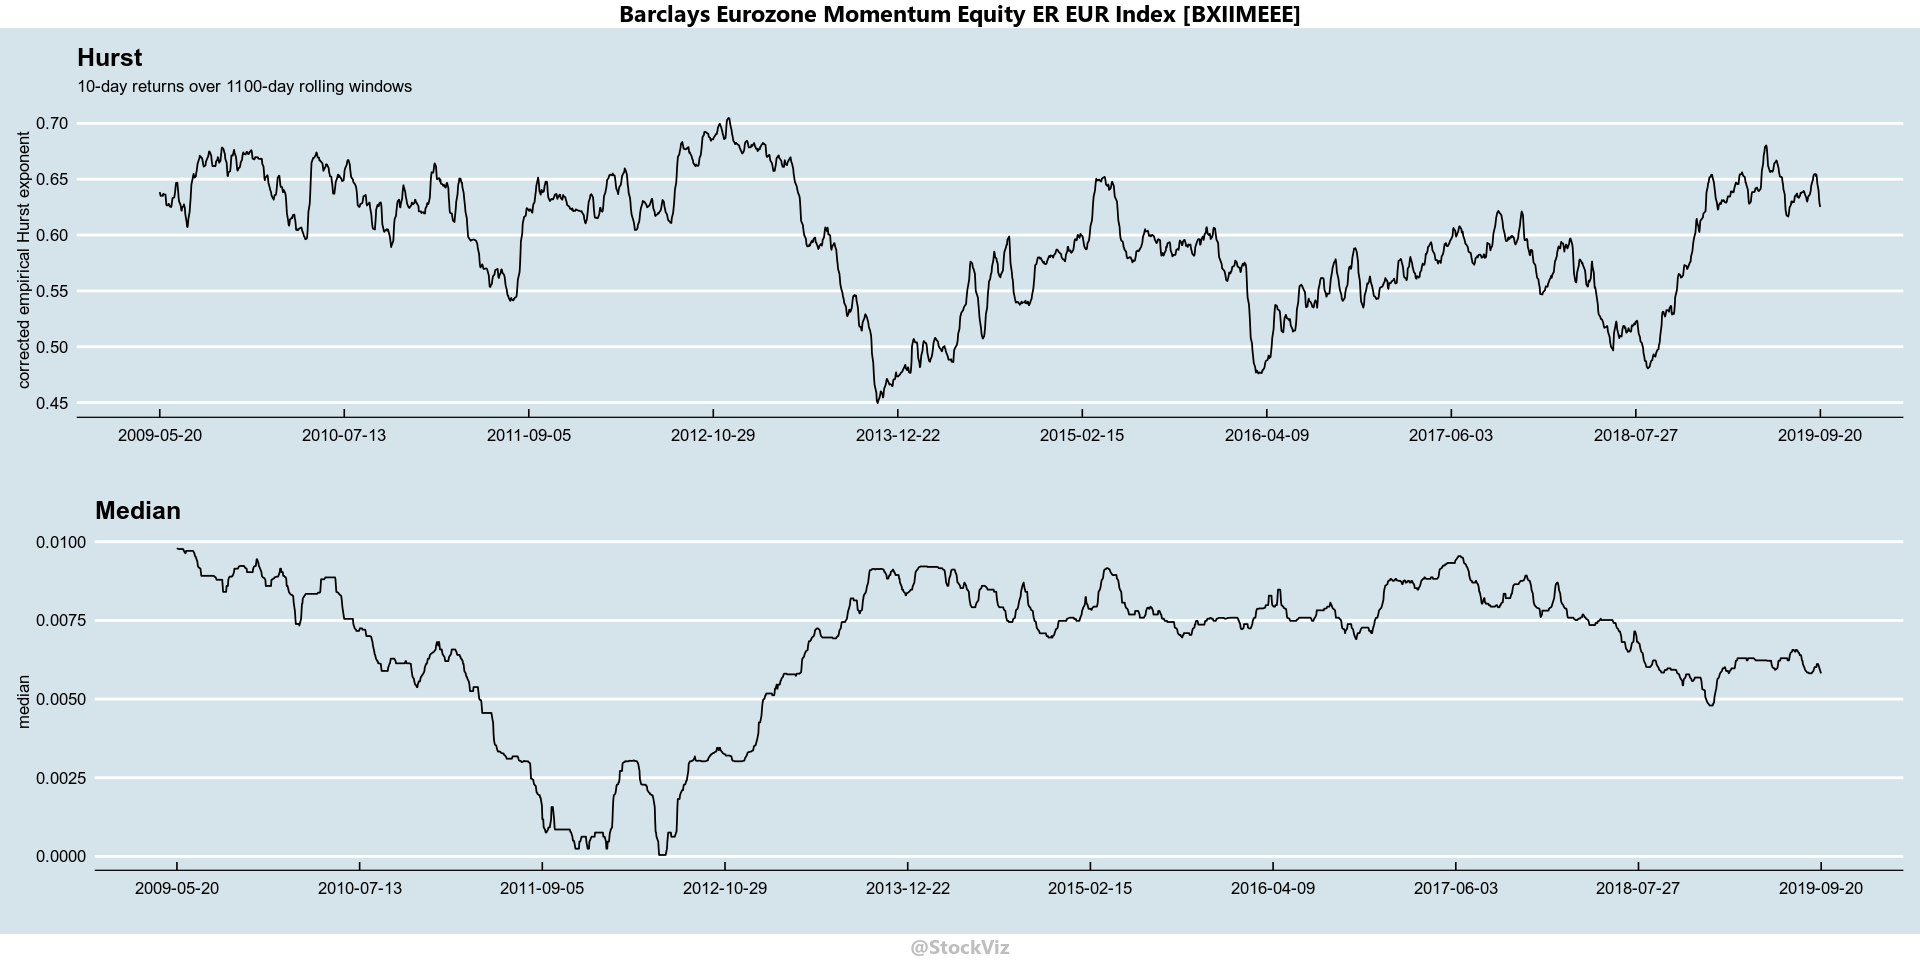

In [7]:
plotExcessReturnHurst('BXIIMEEE')

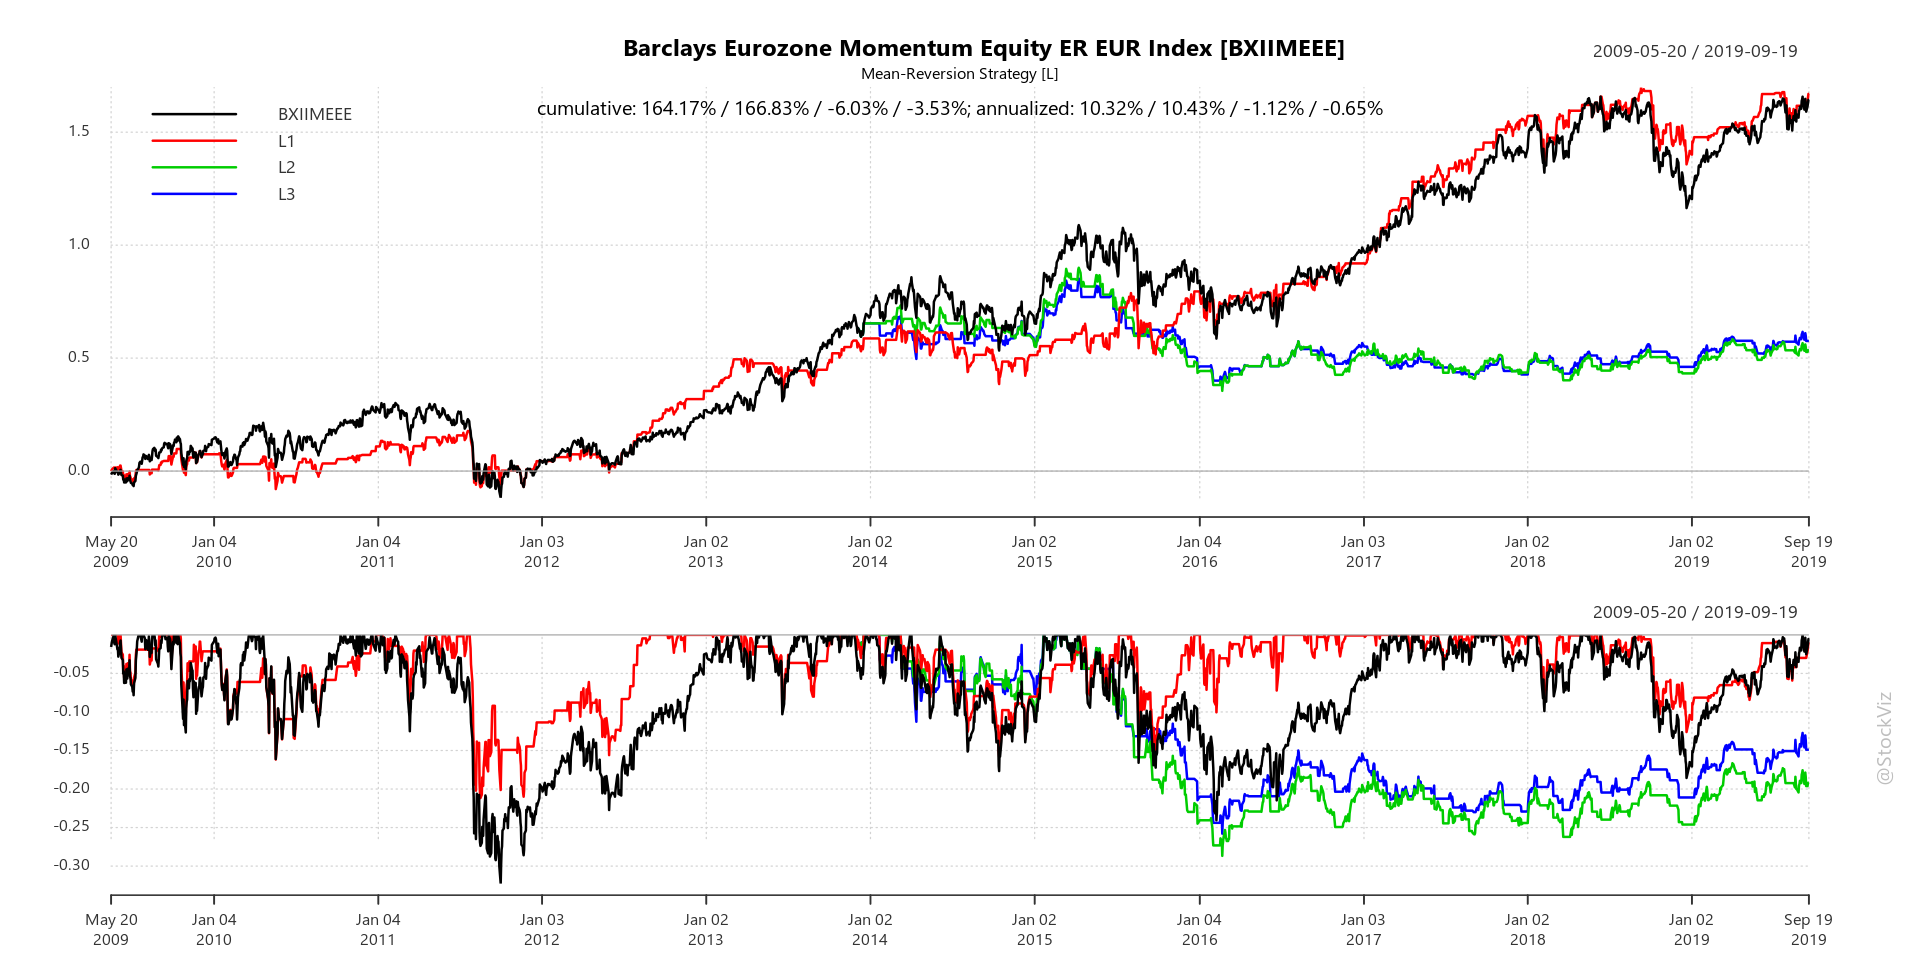

In [8]:
backtestExcessReturn('BXIIMEEE')

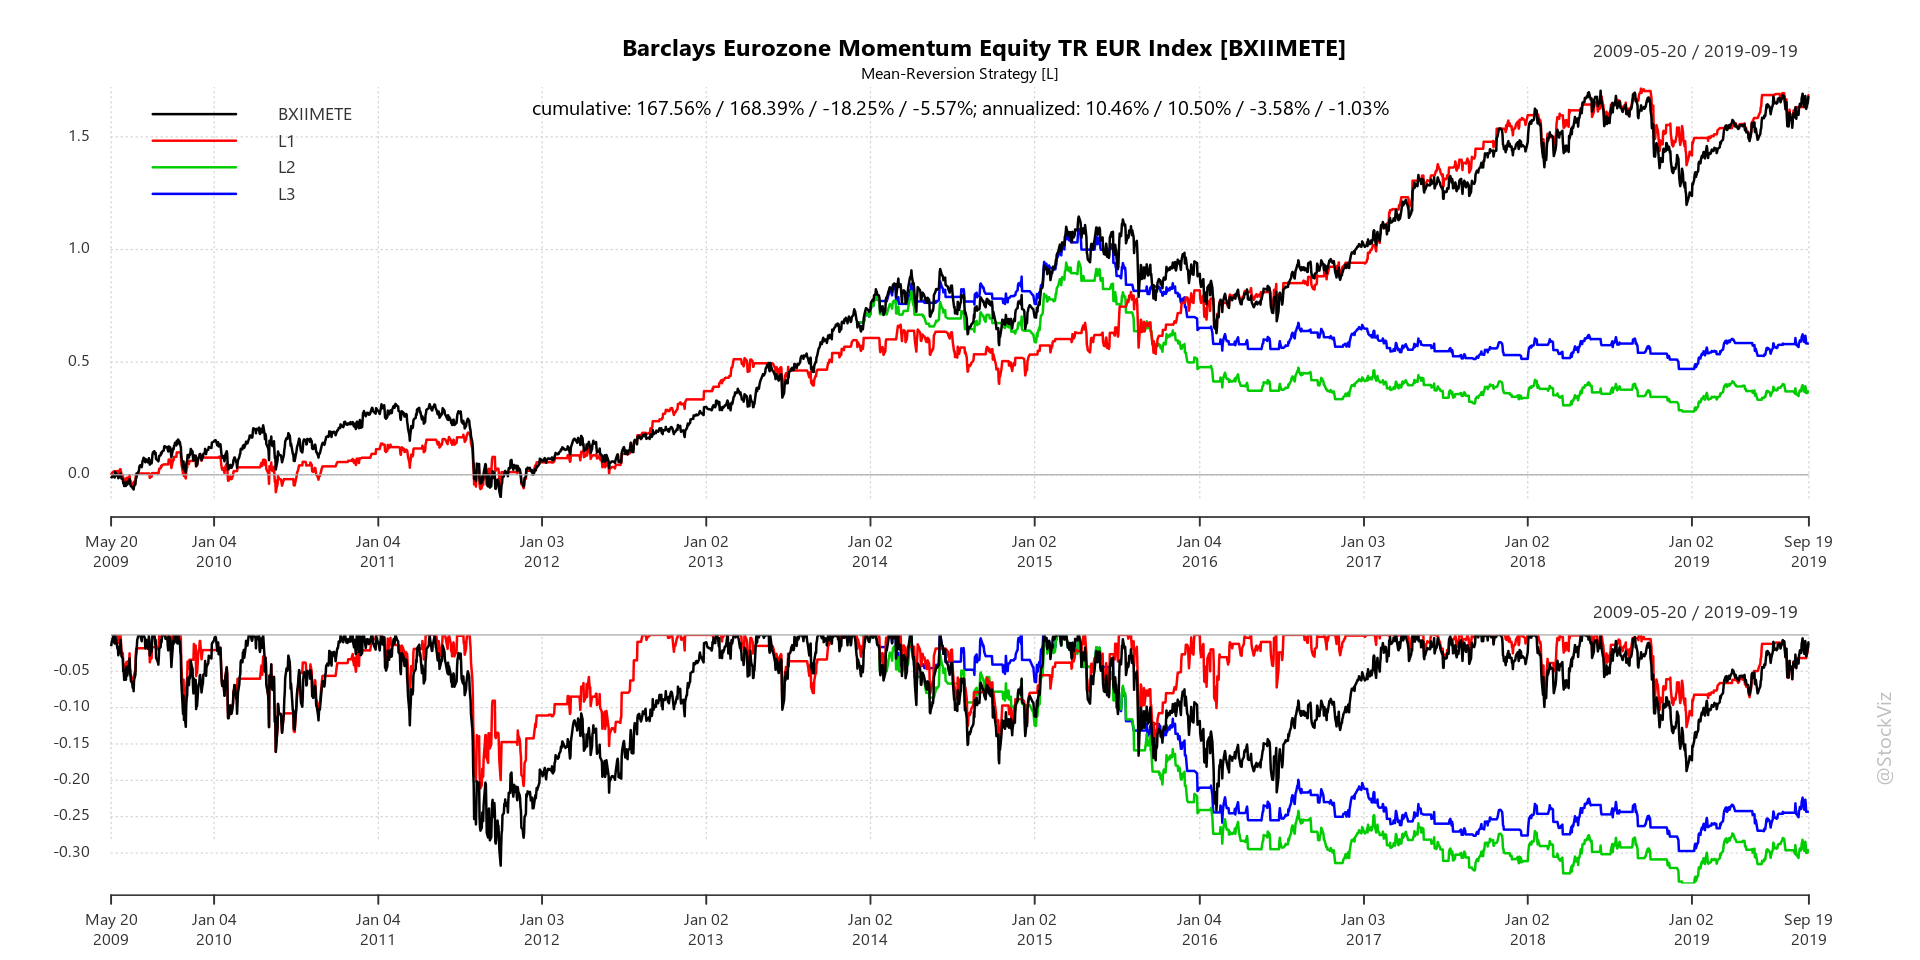

In [9]:
backtestTotalReturn('BXIIMEEE', 'BXIIMETE')

## BXIIMGEG

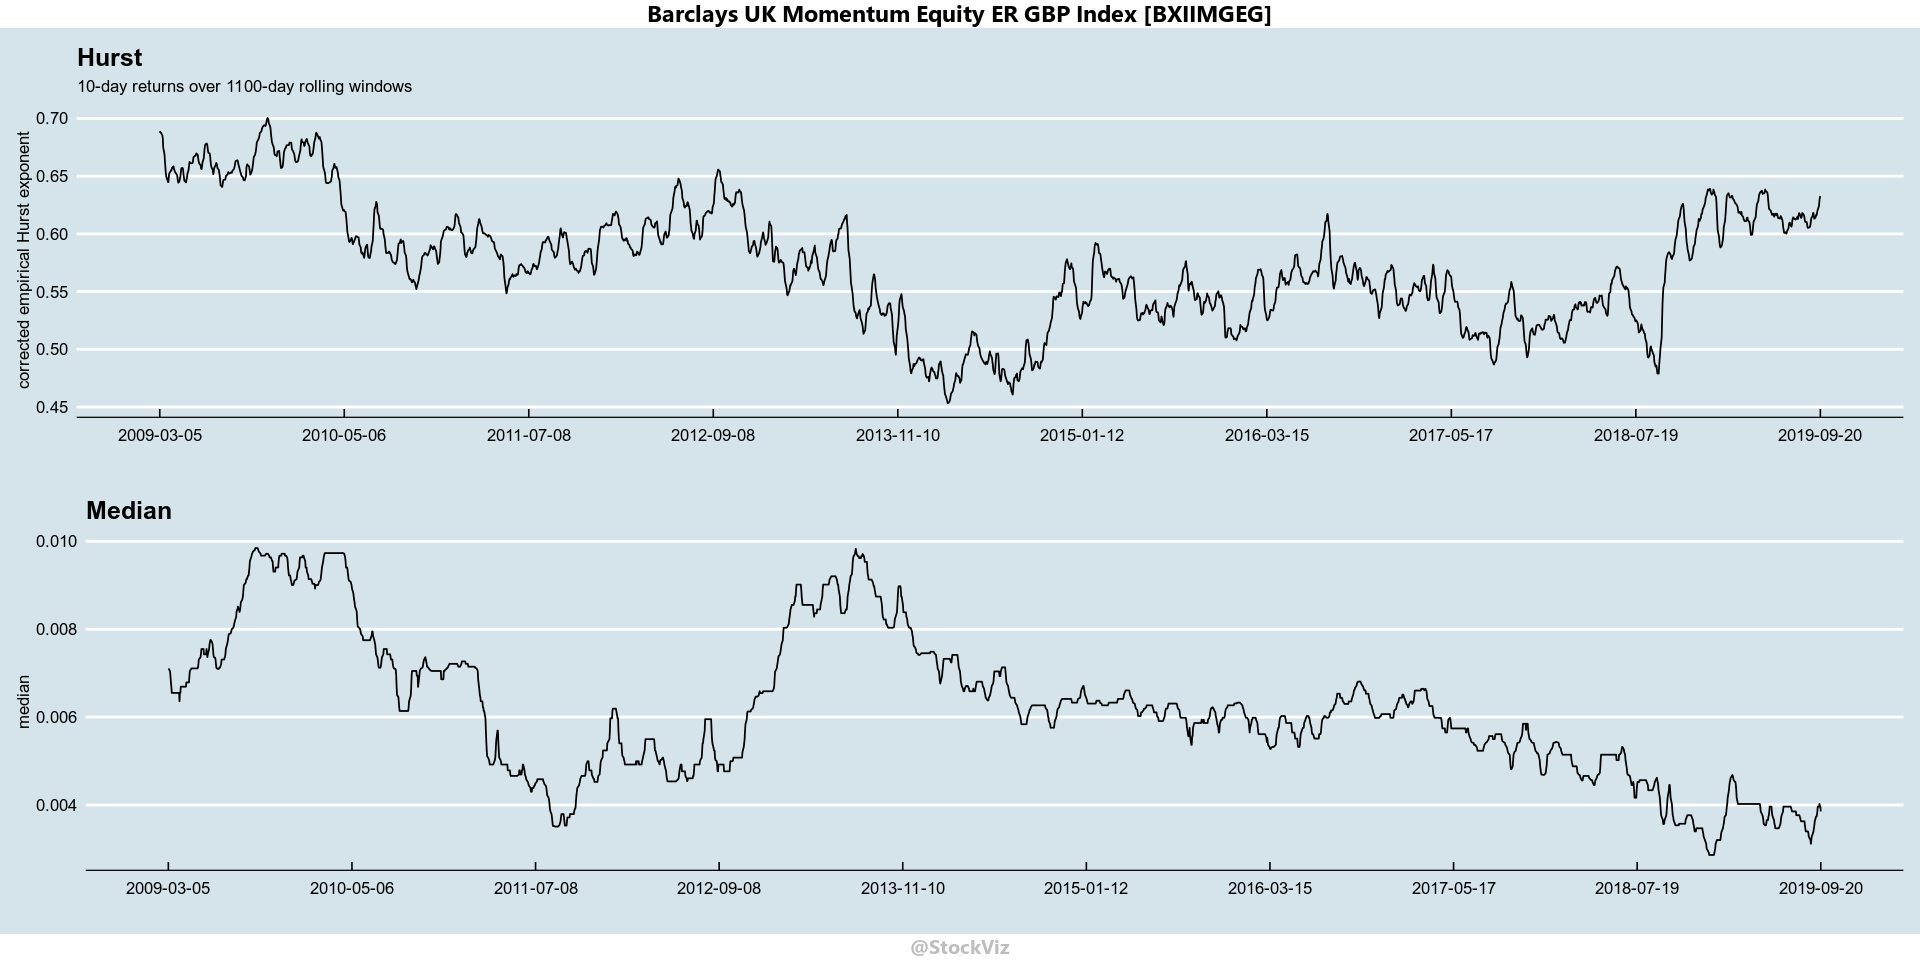

In [10]:
plotExcessReturnHurst('BXIIMGEG')

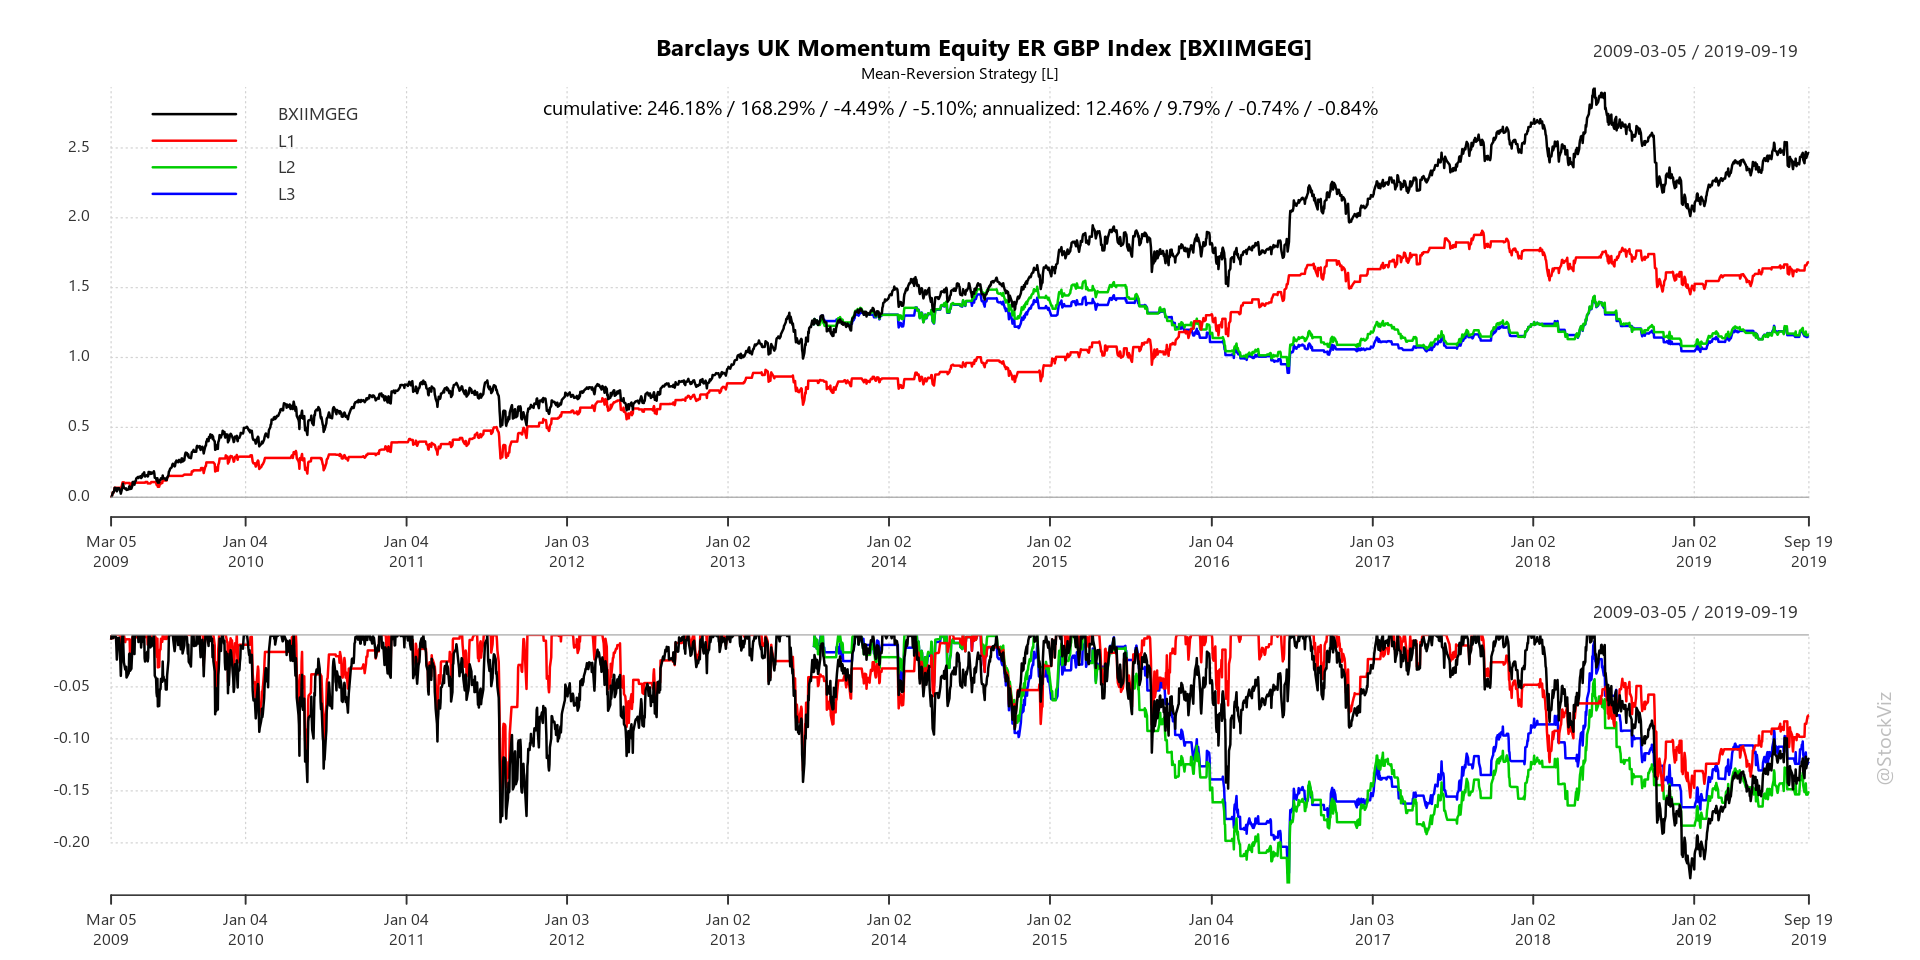

In [11]:
backtestExcessReturn('BXIIMGEG')

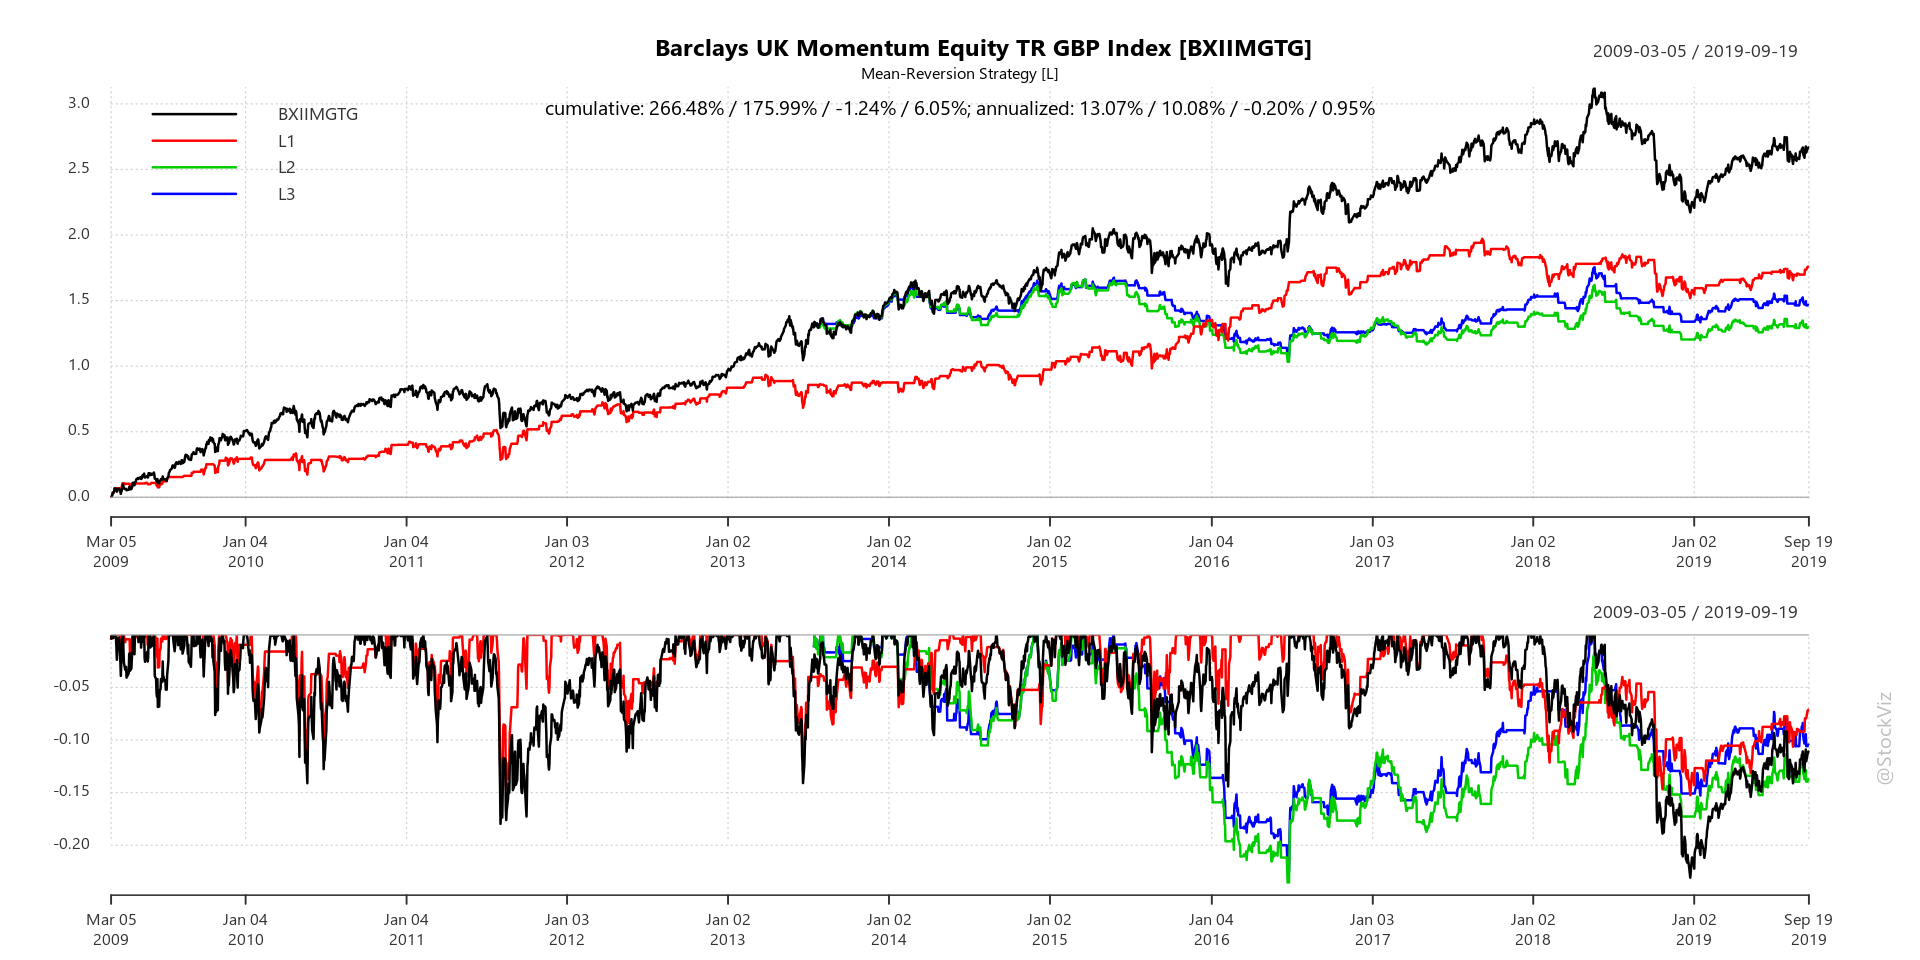

In [12]:
backtestTotalReturn('BXIIMGEG', 'BXIIMGTG')

## BXIIMJEJ

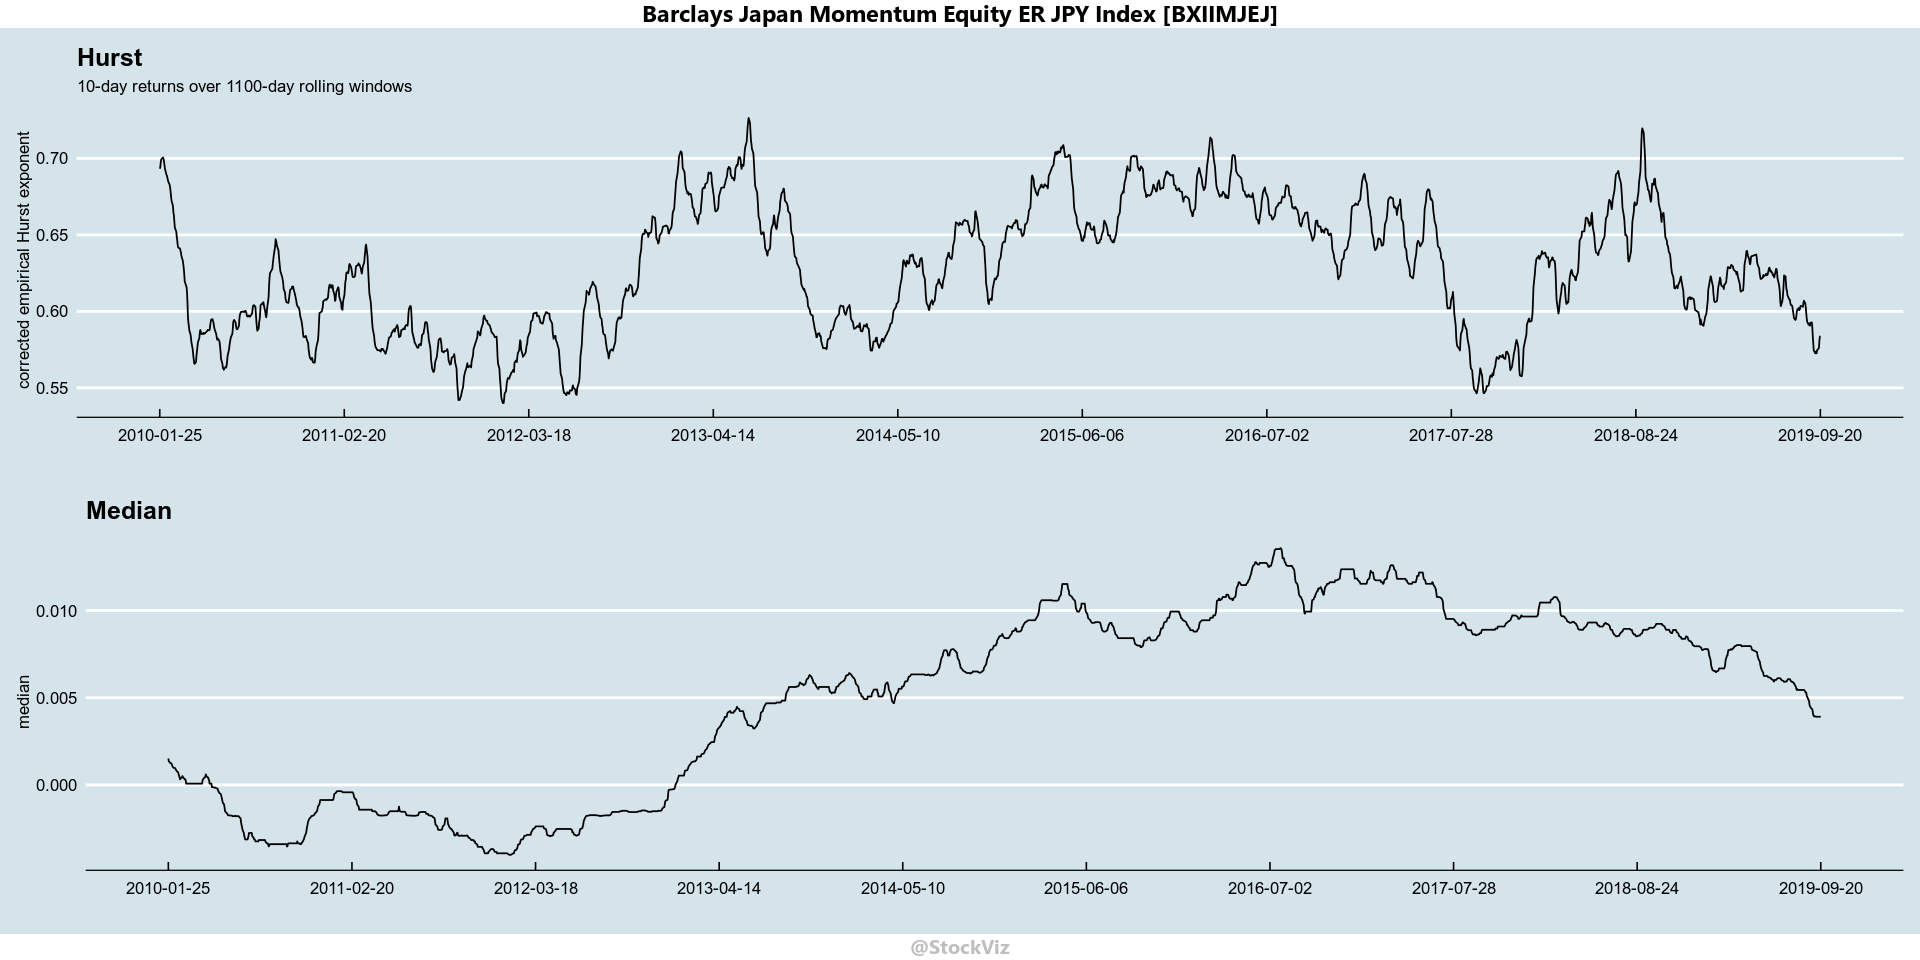

In [13]:
plotExcessReturnHurst('BXIIMJEJ')

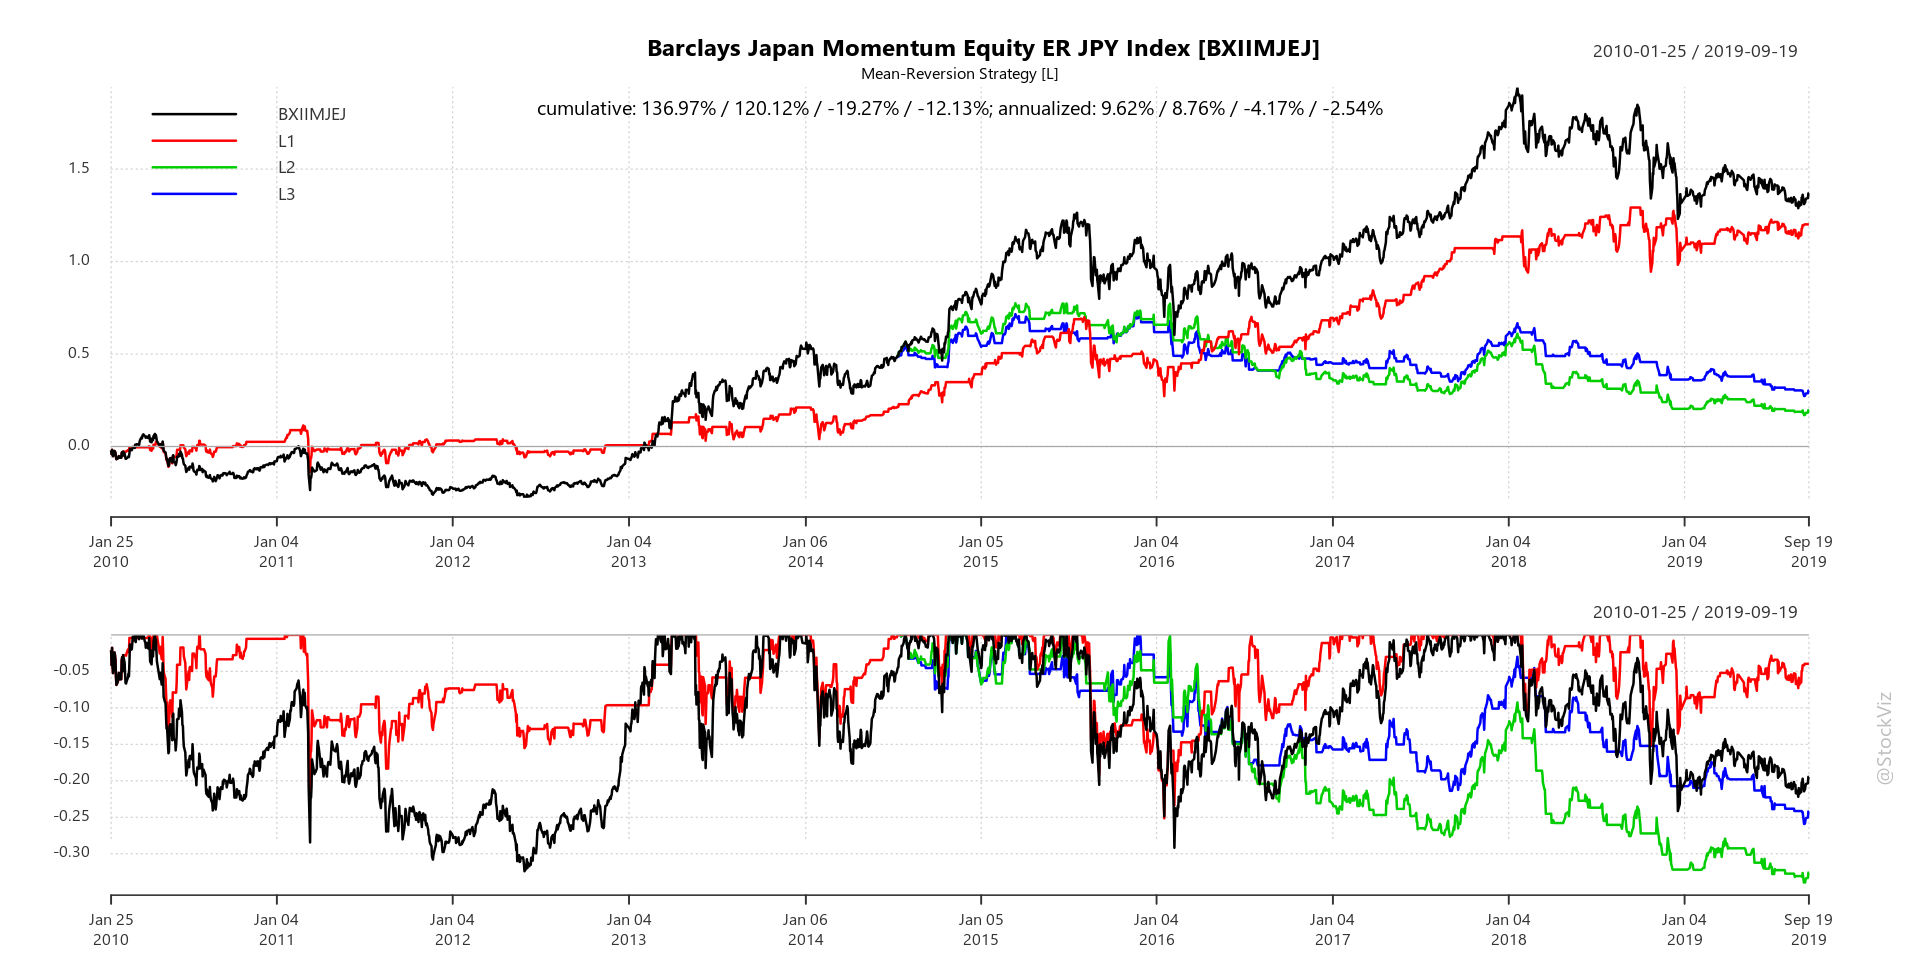

In [14]:
backtestExcessReturn('BXIIMJEJ')

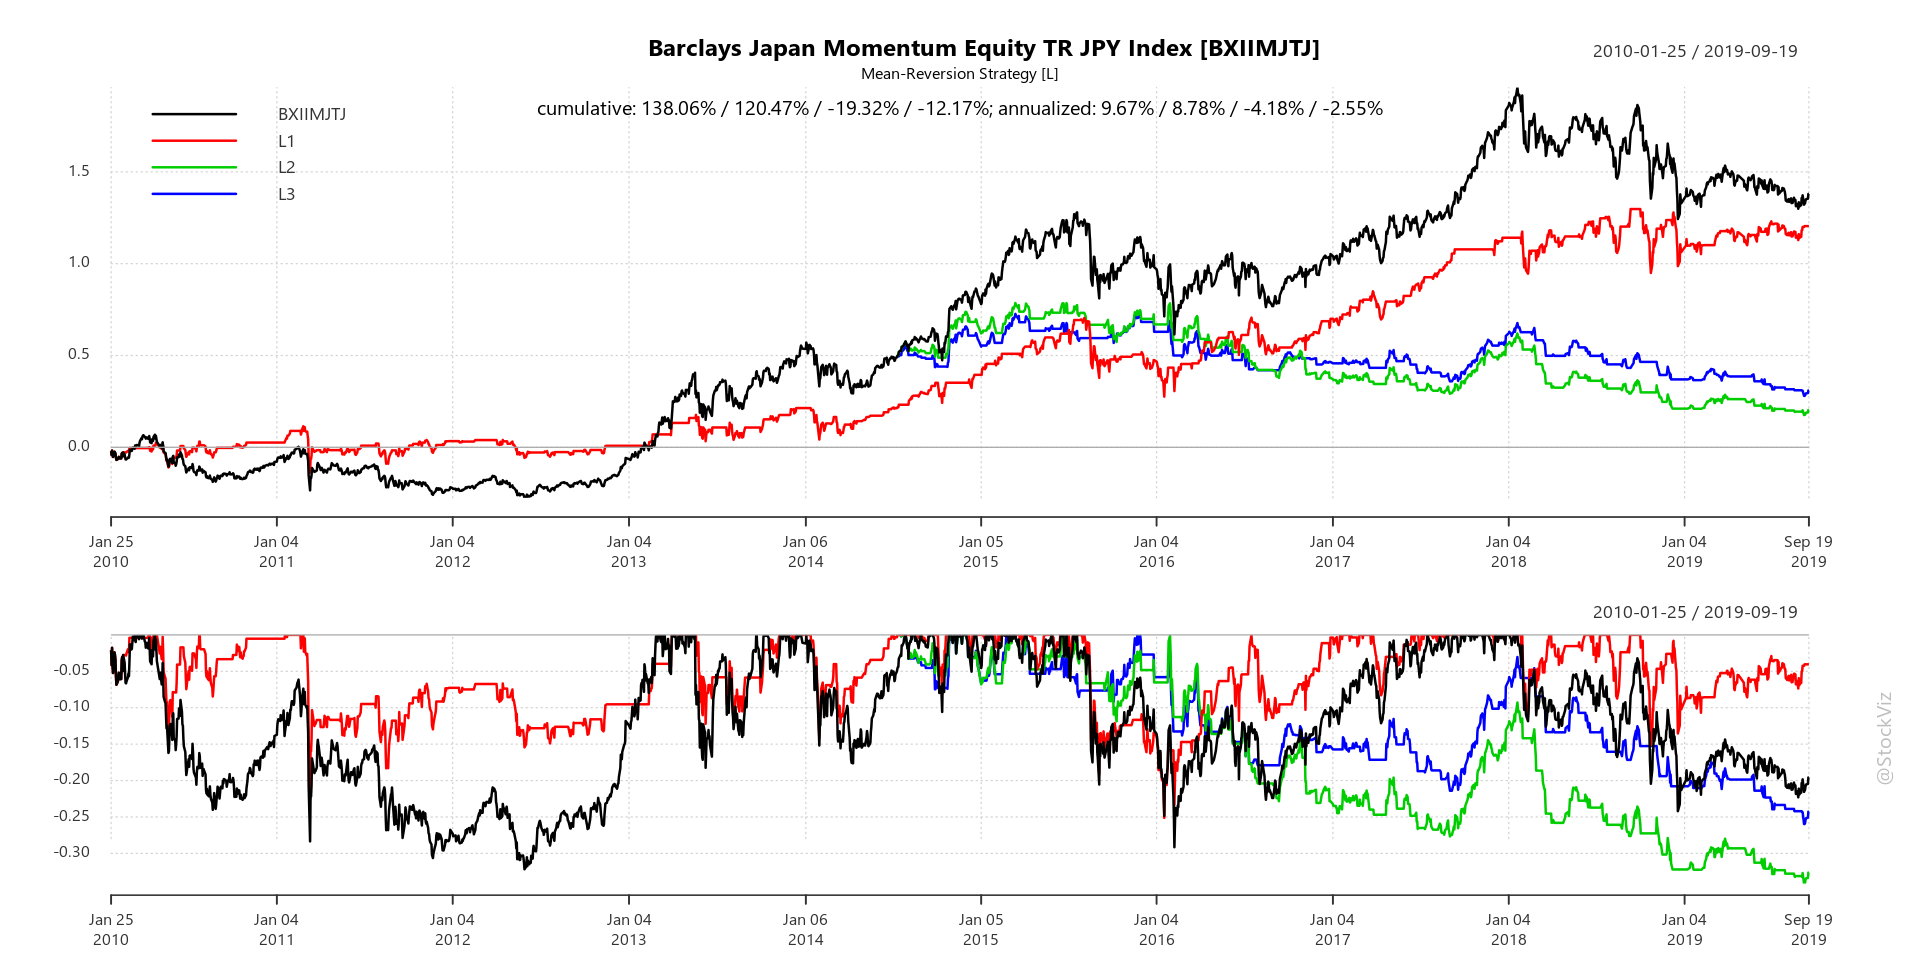

In [15]:
backtestTotalReturn('BXIIMJEJ', 'BXIIMJTJ')

## BXIIMUEU

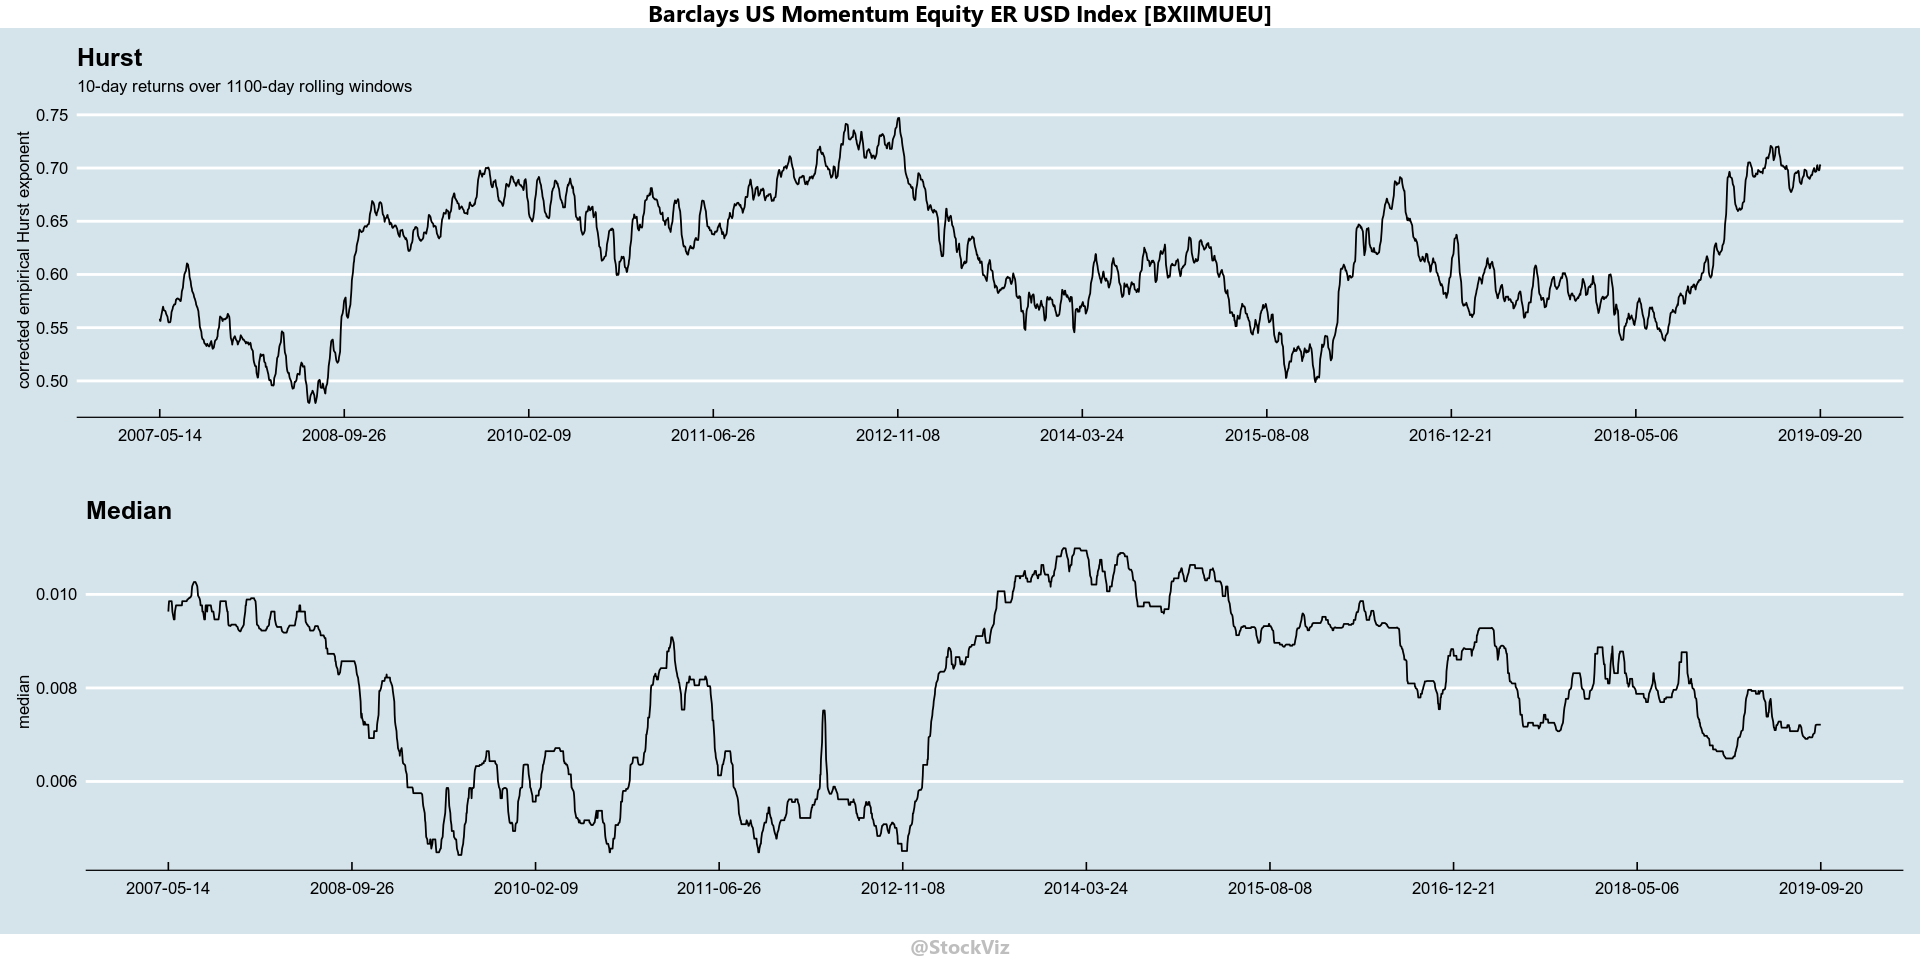

In [16]:
plotExcessReturnHurst('BXIIMUEU')

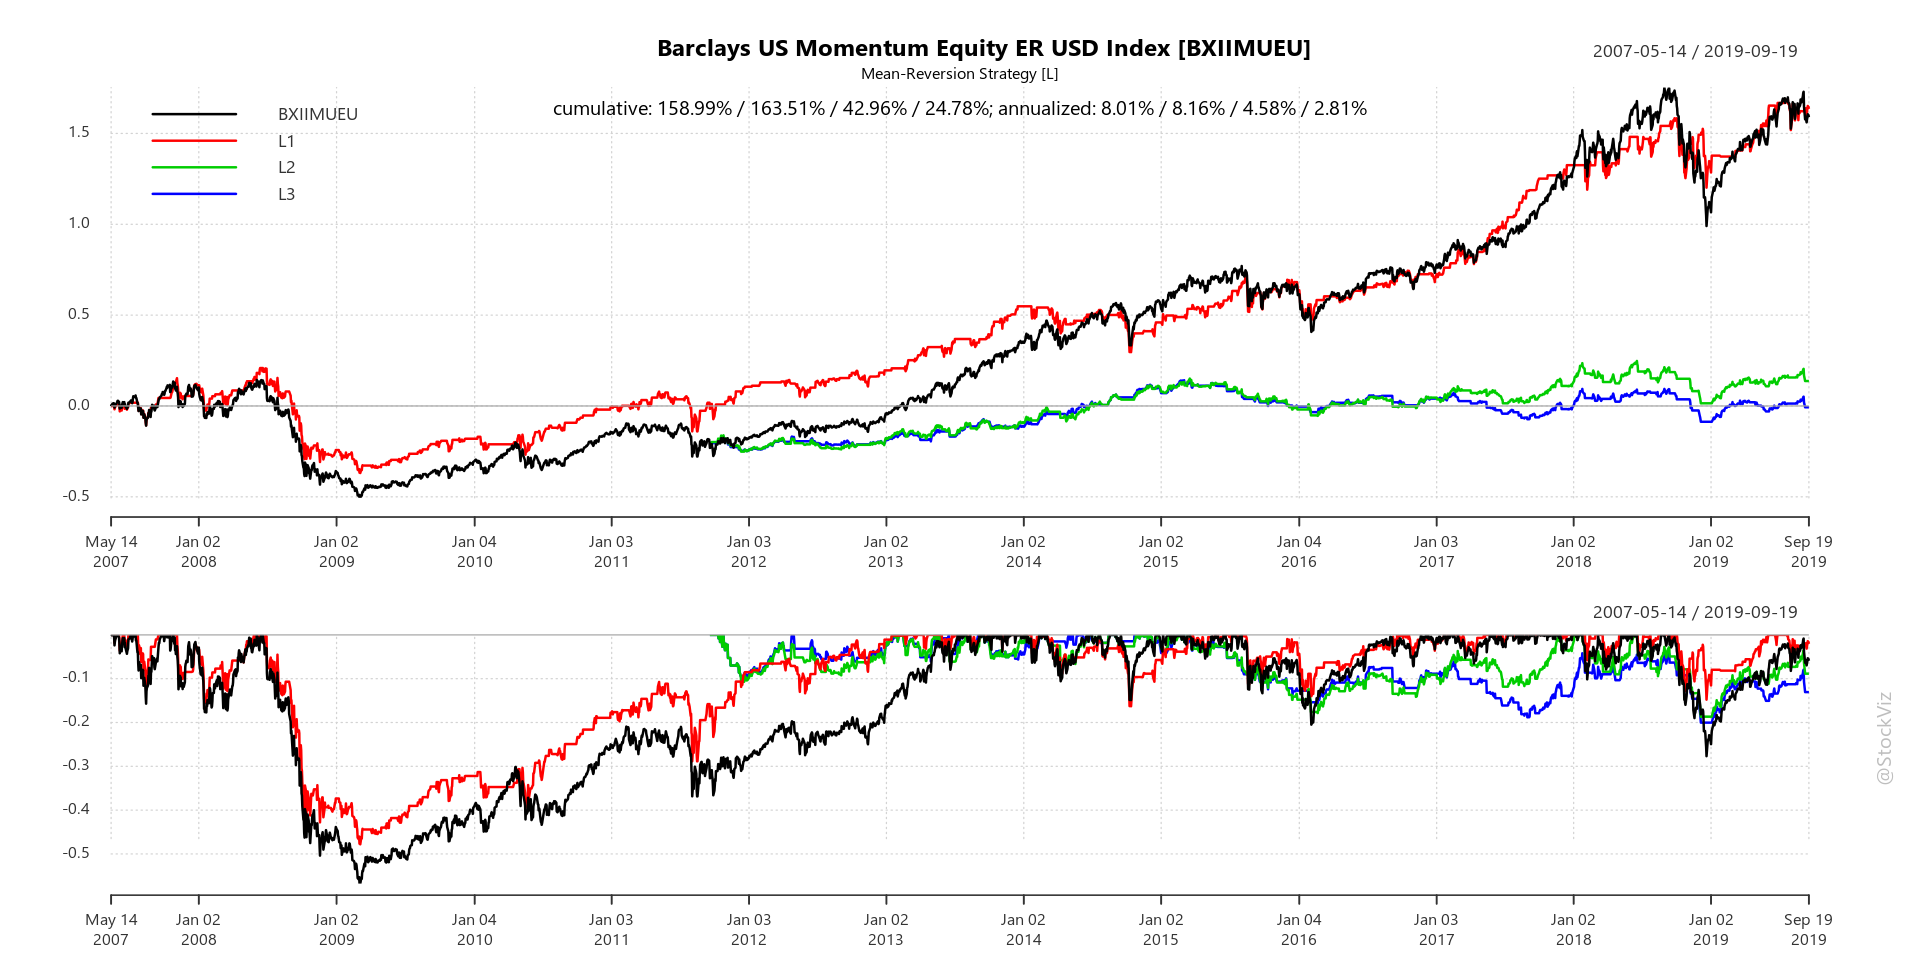

In [17]:
backtestExcessReturn('BXIIMUEU')

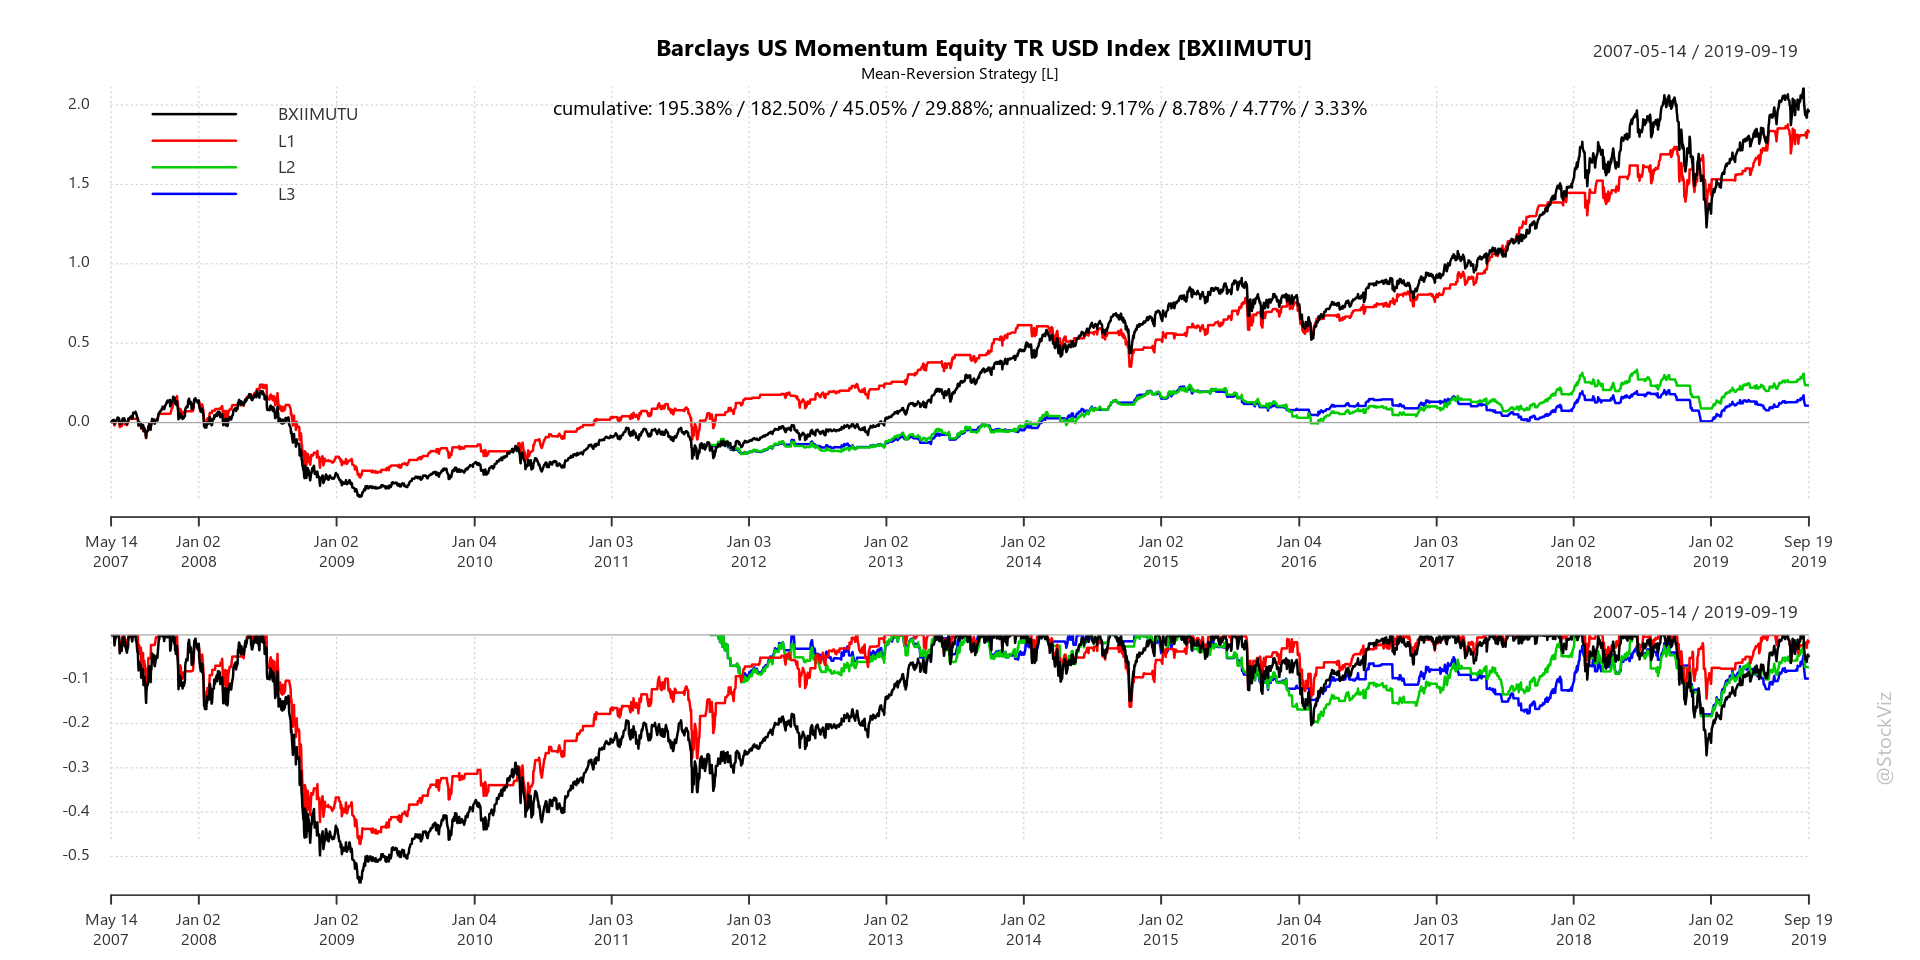

In [18]:
backtestTotalReturn('BXIIMUEU', 'BXIIMUTU')

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!